# Pipeline Rekognisi Wajah dengan Restorasi GFPGAN

## Rekognisi Wajah pada Citra Beresolusi Rendah Menggunakan ArcFace dengan Restorasi Berbasis GFPGAN

**Tujuan Notebook:**
Notebook ini bertujuan untuk mengimplementasikan dan mengevaluasi sebuah pipeline terintegrasi untuk pengenalan wajah pada gambar beresolusi rendah. Pipeline ini terdiri dari dua tahap utama:

1.  **Restorasi Citra:** Menggunakan model **GFPGAN** untuk memperbaiki kualitas dan resolusi citra wajah yang terdegradasi.
2.  **Rekognisi Wajah:** Menggunakan model **ArcFace** untuk mengekstrak fitur (embedding) dari wajah dan melakukan identifikasi.

**Metodologi Evaluasi:**
Kita akan membandingkan dua jalur eksperimental:

- **Jalur A (Baseline):** Rekognisi langsung pada citra resolusi rendah tanpa restorasi.
- **Jalur B (Pipeline Usulan):** Rekognisi pada citra setelah direstorasi oleh GFPGAN.

Kinerja kedua jalur akan dievaluasi menggunakan metrik **Precision, Recall, dan F1-Score** pada berbagai skenario, yaitu berdasarkan **jarak** dan **ketinggian** pengambilan gambar.


### Langkah 1: Instalasi Pustaka yang Diperlukan

Sebelum memulai, kita perlu memastikan semua pustaka Python yang dibutuhkan telah terinstal. Sel di bawah ini akan menjalankan perintah `pip install` untuk `gfpgan`, `deepface`, dan pustaka pendukung lainnya. Cukup jalankan sel ini sekali saja.


In [23]:
%pip install gfpgan
%pip install deepface
%pip install facexlib
%pip install -r ../model_gfpgan/requirements.txt

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Langkah 2: Inisialisasi & Impor Pustaka

Setelah instalasi selesai, sel di bawah ini akan mengimpor semua pustaka yang kita butuhkan. Pustaka-pustaka ini mencakup operasi file (`os`, `glob`), pemrosesan gambar (`cv2`), komputasi numerik (`numpy`), dan `deepface` untuk rekognisi.


In [24]:
import os
import glob
import cv2
import numpy as np
from collections import defaultdict

# --- Konfigurasi Path --- 
# Mendefinisikan path absolut untuk direktori utama proyek, data, dan hasil
BASE_DIR = os.path.abspath('.')
GALLERY_PATH = os.path.join(BASE_DIR, 'data', 'gallery')
PROBES_PATH = os.path.join(BASE_DIR, 'data', 'probes')
RESULTS_PATH = os.path.join(BASE_DIR, 'results')

# Pastikan folder results ada
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"Notebook berjalan di: {BASE_DIR}")
print(f"Galeri Referensi: {GALLERY_PATH}")
print(f"Citra Uji (Probes): {PROBES_PATH}")

Notebook berjalan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi
Galeri Referensi: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\data\gallery
Citra Uji (Probes): d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\data\probes


### Langkah 2: Fungsi-Fungsi Utilitas

Di sini kita mendefinisikan fungsi-fungsi bantuan. Fungsi `parse_filename` sangat penting karena perannya adalah untuk mengekstrak informasi metadata (seperti ID subjek, jarak, dan ketinggian) langsung dari nama file gambar. Informasi ini adalah kunci untuk melakukan evaluasi perbandingan kinerja pipeline kita nanti.


In [25]:
def parse_filename(filename):
    """
    Mengekstrak metadata dari nama file dataset DnHFaces.
    Mengembalikan dictionary berisi metadata atau None jika format tidak valid.
    """
    try:
        base_name = os.path.basename(filename)
        parts = os.path.splitext(base_name)[0].split('_')

        if len(parts) < 5:
            return None

        subject_id = parts[0]
        height_id = parts[2]
        distance_id = parts[4]

        if height_id == 'na' or distance_id == 'na':
            return None

        distance = 17 - (int(distance_id) / 2)

        if int(distance_id) > 24:
            distance_category = 'dekat'
        elif 14 <= int(distance_id) <= 24:
            distance_category = 'menengah'
        else:
            distance_category = 'jauh'

        height_category = None
        if height_id == '3':
            height_category = 'rendah'
        elif height_id == '5':
            height_category = 'tinggi'
        
        if not height_category:
            return None

        return {
            'subject_id': subject_id,
            'distance_m': distance,
            'distance_category': distance_category,
            'height_id': height_id,
            'height_category': height_category
        }
    except (IndexError, ValueError):
        return None

# Contoh penggunaan
test_file = 'ab_gp_3_eo_20.JPG'
metadata = parse_filename(test_file)
print(f'Metadata untuk {test_file}: {metadata}')

Metadata untuk ab_gp_3_eo_20.JPG: {'subject_id': 'ab', 'distance_m': 7.0, 'distance_category': 'menengah', 'height_id': '3', 'height_category': 'rendah'}


### Langkah 3: Definisi Fungsi Pipeline

Pada bagian ini, kita mendefinisikan fungsi-fungsi inti untuk pipeline kita.

- **`restore_face(image_path)`**: Fungsi ini tidak memuat model GFPGAN secara langsung, melainkan bertindak sebagai _wrapper_ yang memanggil skrip `inference_gfpgan.py` dari command line. Ini adalah cara yang efisien dan modular untuk mengintegrasikan fungsionalitas restorasi ke dalam alur kerja kita. Hasil restorasi akan disimpan di subfolder sementara di dalam direktori `results`.
- **`get_embedding(image_path)`**: Fungsi ini menggunakan kemudahan dari pustaka `DeepFace` untuk mendapatkan representasi vektor (embedding) dari sebuah gambar wajah. Kita secara spesifik memilih model 'ArcFace' sesuai dengan metodologi penelitian.


In [34]:
import subprocess
from deepface import DeepFace

#   --- PERBAIKAN: Tentukan path absolut ke Python di dalam .venv ---
#   Ini memastikan subprocess memanggil Python yang benar
PROJECT_ROOT = os.path.abspath(os.path.join(BASE_DIR, '..'))
VENV_PYTHON_PATH = os.path.join(PROJECT_ROOT, '.venv', 'Scripts', 'python.exe')

#   Periksa apakah path python.exe valid
if not os.path.exists(VENV_PYTHON_PATH):
#   Fallback ke python biasa jika tidak ditemukan, meskipun mungkin gagal
    print(f"PERINGATAN: Tidak dapat menemukan python.exe di {VENV_PYTHON_PATH}")
    VENV_PYTHON_PATH = "python"

#   Tentukan path ke skrip inferensi GFPGAN dan direktori output sementara
GFPGAN_SCRIPT_PATH = os.path.join(PROJECT_ROOT, 'model_gfpgan', 'inference_gfpgan.py')
TEMP_RESTORE_DIR = os.path.join(RESULTS_PATH, 'restored_temp')
os.makedirs(TEMP_RESTORE_DIR, exist_ok=True)

def restore_face(image_path):
    """Menjalankan restorasi GFPGAN pada satu gambar melalui command line."""
    if not os.path.exists(image_path):
        print(f"Error: File input tidak ditemukan di {image_path}")
        return None

    command = [
        VENV_PYTHON_PATH,
        GFPGAN_SCRIPT_PATH,
        '-i', image_path,
        '-o', TEMP_RESTORE_DIR,
        '-v', '1.4',
        '-s', '2',
        # '--ext', 'jpg',
        # '--only_center_face',
        '--bg_upsampler', 'None'
    ]

    try:
        subprocess.run(command, check=True, capture_output=True, encoding='utf-8', errors='ignore')
    except subprocess.CalledProcessError as e:
        print(f"Error saat menjalankan GFPGAN untuk {os.path.basename(image_path)}:")
        print(e.stderr)
        return None

    img_name = os.path.basename(image_path)
    base, ext = os.path.splitext(img_name)
    restored_face_path = os.path.join(TEMP_RESTORE_DIR, 'restored_faces', f"{base}.jpg")

    if os.path.exists(restored_face_path):
        print(f"✅: Berhasil direstorasi dengan path {restored_face_path}")
        return restored_face_path
    else:
        print(f"❌: File hasil restorasi tidak ditemukan di {restored_face_path}")
        return None

def get_embedding(image_path):
    """Mendapatkan embedding 512-dimensi dari gambar menggunakan DeepFace (ArcFace)."""
    if not os.path.exists(image_path):
        return None
    try:
        embedding_obj = DeepFace.represent(
            img_path=image_path,
            model_name='ArcFace',
            enforce_detection=False,
            detector_backend='retinaface'
        )
        return embedding_obj[0]['embedding']
    except (ValueError, AttributeError, IndexError) as e:
        return None

print(f"Fungsi pipeline restore_face dan get_embedding telah siap digunakan.")
print(f"Subprocess akan menggunakan Python dari: {VENV_PYTHON_PATH}")

Fungsi pipeline restore_face dan get_embedding telah siap digunakan.
Subprocess akan menggunakan Python dari: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\.venv\Scripts\python.exe


### Langkah 4: Pembuatan Galeri Referensi

Sebelum kita bisa mengidentifikasi wajah pada gambar uji, kita perlu membuat sebuah 'database' atau 'galeri' dari wajah-wajah yang sudah kita kenal. Kita akan memproses setiap gambar di folder `gallery`, mengekstrak fitur wajahnya menggunakan ArcFace, dan menyimpannya dalam sebuah dictionary. Key dari dictionary ini adalah ID subjek (misalnya 'a', 'b', 'c') dan value-nya adalah vektor fitur (embedding) dari wajah mereka.


In [35]:
gallery_embeddings = {}
gallery_files = glob.glob(os.path.join(GALLERY_PATH, '*.jpg'))

print(f"Membuat database fitur dari {len(gallery_files)} gambar di galeri...")

for g_file in gallery_files:
    subject_id = os.path.basename(g_file).split('_')[0]
    
    # Langsung dapatkan embedding dari path file
    embedding = get_embedding(g_file)
    if embedding is not None:
        gallery_embeddings[subject_id] = embedding

print(f"Database fitur galeri berhasil dibuat untuk subjek: {list(gallery_embeddings.keys())}")

Membuat database fitur dari 11 gambar di galeri...
Database fitur galeri berhasil dibuat untuk subjek: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']


### Langkah 5: Eksekusi Pipeline Utama

Ini adalah inti dari eksperimen kita. Sel kode di bawah akan melakukan iterasi pada semua gambar uji (`probes`). Untuk setiap gambar, kedua jalur (A dan B) akan dieksekusi:

1.  **Parsing Metadata:** Informasi jarak dan ketinggian diekstrak dari nama file.
2.  **Jalur A (Baseline):** Gambar asli langsung diproses oleh ArcFace untuk mendapatkan prediksi identitas.
3.  **Jalur B (Pipeline Usulan):** Gambar asli pertama-tama direstorasi oleh GFPGAN, kemudian hasilnya diproses oleh ArcFace untuk mendapatkan prediksi.
4.  **Penyimpanan Hasil:** Hasil dari kedua jalur (prediksi A, prediksi B), beserta data ground truth dan metadata, disimpan dalam sebuah list untuk dievaluasi pada langkah berikutnya.


In [38]:
from scipy.spatial.distance import cosine
from tqdm.notebook import tqdm # Menggunakan tqdm versi notebook
import time

def find_best_match(probe_embedding, gallery_embeddings):
    """Mencari padanan terbaik dari galeri berdasarkan cosine similarity."""
    if probe_embedding is None:
        return None
    min_dist = float('inf')
    best_match_id = None
    for subject_id, gallery_embedding in gallery_embeddings.items():
        if gallery_embedding is None:
            continue
        dist = cosine(probe_embedding, gallery_embedding)
        if dist < min_dist:
            min_dist = dist
            best_match_id = subject_id
    return best_match_id

probe_files = glob.glob(os.path.join(PROBES_PATH, '*.JPG'))
results = []

print(f"Memulai pemrosesan {len(probe_files)} citra uji...")
start_time = time.time()

# Menggunakan tqdm untuk progress bar
for probe_path in tqdm(probe_files):
    metadata = parse_filename(probe_path)
    if not metadata:
        continue

    ground_truth_subjects = metadata['subject_id']

    # --- Jalur A (Tanpa Restorasi) --- 
    embedding_A = get_embedding(probe_path)
    prediction_A = find_best_match(embedding_A, gallery_embeddings)

    # --- Jalur B (Dengan Restorasi) --- 
    restored_face_path = restore_face(probe_path)
    embedding_B = get_embedding(restored_face_path) if restored_face_path else None
    prediction_B = find_best_match(embedding_B, gallery_embeddings)

    # Cek apakah prediksi benar
    is_correct_A = prediction_A is not None and any(char in prediction_A for char in ground_truth_subjects)
    is_correct_B = prediction_B is not None and any(char in prediction_B for char in ground_truth_subjects)

    results.append({
        'file': os.path.basename(probe_path),
        'metadata': metadata,
        'ground_truth': ground_truth_subjects,
        'prediction_A': prediction_A,
        'prediction_B': prediction_B,
        'is_correct_A': is_correct_A,
        'is_correct_B': is_correct_B
    })

end_time = time.time()
print(f"Selesai memproses {len(results)} citra uji yang relevan dalam {end_time - start_time:.2f} detik.")

Memulai pemrosesan 1364 citra uji...


  0%|          | 0/1364 [00:00<?, ?it/s]

❌: File hasil restorasi tidak ditemukan di d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\restored_temp\restored_faces\a_gp_3_ef_00.jpg
❌: File hasil restorasi tidak ditemukan di d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\restored_temp\restored_faces\a_gp_3_ef_01.jpg
✅: Berhasil direstorasi dengan path d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\restored_temp\restored_faces\a_gp_3_ef_02.jpg
✅: Berhasil direstorasi dengan path d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\restored_temp\restored_faces\a_gp_3_ef_03.jpg
✅: Berhasil direstorasi dengan path d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\restored_temp\restored_faces\a_gp_3_ef_04.jpg
✅: Berhasil direstorasi dengan path d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\restored_temp\restored_faces\a_gp_3_ef_05.jpg
✅: Berhasil direstorasi dengan path d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\restored_temp\restored_faces\a_gp_3_ef_06.jpg

In [58]:
#Simpan results kedalam file
import json
# Tentukan path untuk menyimpan file results
results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results.json')
# Simpan variabel results ke dalam file JSON
try:
    with open(results_file_path, 'w') as f:
      json.dump(results, f, indent=4) # indent=4 agar file mudah dibaca
    print(f"Variabel 'results' berhasil disimpan ke: {results_file_path}")
except Exception as e:
    print(f"Gagal menyimpan variabel 'results': {e}")

Variabel 'results' berhasil disimpan ke: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\pipeline_results.json


### Langkah 6: Fungsi Evaluasi

Setelah semua gambar uji diproses, kita perlu cara untuk mengukur dan membandingkan kinerjanya. Sel di bawah ini mendefinisikan fungsi `calculate_metrics` yang menghitung True Positives (TP), False Positives (FP), dan False Negatives (FN), yang kemudian digunakan untuk menghitung Precision, Recall, dan F1-Score. Fungsi `print_results` digunakan untuk menampilkan hasil ini dalam format tabel yang mudah dibaca.


In [41]:
def calculate_metrics(grouped_results):
    """Menghitung metrik evaluasi dari hasil yang sudah dikelompokkan."""
    metrics = {}
    for key in ['A', 'B']:
        tp = sum(1 for r in grouped_results if r[f'is_correct_{key}'])
        fp = len(grouped_results) - tp # False Positive
        # Dalam kasus identifikasi, FN bisa dianggap sebagai jumlah yang salah diidentifikasi, yang sama dengan FP dalam perhitungan ini.
        fn = fp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        metrics[key] = {'precision': precision, 'recall': recall, 'f1': f1_score, 'count': len(grouped_results)}
    return metrics

def print_results(title, results_by_category):
    """Mencetak hasil evaluasi dalam format tabel."""
    print(f"--- {title} ---")
    print('| Category   | Pipeline | Precision | Recall    | F1-Score  | Count | F1-Improvement |')
    print('|------------|----------|-----------|-----------|-----------|-------|----------------|')
    sorted_keys = sorted(results_by_category.keys(), key=lambda x: ('dekat', 'menengah', 'jauh', 'rendah', 'tinggi').index(x))
    for category in sorted_keys:
        metrics = results_by_category[category]
        f1_A = metrics['A']['f1']
        f1_B = metrics['B']['f1']
        improvement = ((f1_B - f1_A) / f1_A * 100) if f1_A > 0 else float('inf')
        
        print(f'| {category:<10} | Jalur A  | {metrics["A"]["precision"]:.5f}   | {metrics["A"]["recall"]:.5f}   | {metrics["A"]["f1"]:.5f}   | {metrics["A"]["count"]:<5} |                |')
        
        print(f'|            | Jalur B  | {metrics["B"]["precision"]:.5f}   | {metrics["B"]["recall"]:.5f}   | {metrics["B"]["f1"]:.5f}   | {metrics["B"]["count"]:<5} | {improvement:+.2f}%      |')
    print('|------------|----------|-----------|-----------|-----------|-------|----------------|')


Fungsi evaluasi `calculate_metrics` dan `print_results` telah diperbaiki.


### Langkah 7: Analisis Hasil

Langkah terakhir adalah menjalankan evaluasi dan menganalisis hasilnya. Kode di bawah ini akan mengelompokkan hasil berdasarkan skenario yang telah kita definisikan (jarak dan ketinggian) dan kemudian memanggil fungsi `print_results` untuk menampilkan tabel perbandingan kinerja Jalur A dan Jalur B untuk setiap skenario.


In [52]:
# 1. Analisis berdasarkan Jarak
results_by_distance = defaultdict(list)
for r in results:
    results_by_distance[r['metadata']['distance_category']].append(r)

metrics_by_distance = {}
for category, res_list in results_by_distance.items():
    metrics_by_distance[category] = calculate_metrics(res_list)

print_results("Analisis Berdasarkan Jarak", metrics_by_distance)

# 2. Analisis berdasarkan Ketinggian
results_by_height = defaultdict(list)
for r in results:
    results_by_height[r['metadata']['height_category']].append(r)

metrics_by_height = {}
for category, res_list in results_by_height.items():
    metrics_by_height[category] = calculate_metrics(res_list)

print_results("Analisis Berdasarkan Ketinggian", metrics_by_height)

--- Analisis Berdasarkan Jarak ---
| Category   | Pipeline | Precision | Recall    | F1-Score  | Count | F1-Improvement |
|------------|----------|-----------|-----------|-----------|-------|----------------|
| dekat      | Jalur A  | 0.65152   | 0.65152   | 0.65152   | 132   |                |
|            | Jalur B  | 0.69697   | 0.69697   | 0.69697   | 132   | +6.98%      |
| menengah   | Jalur A  | 0.65289   | 0.65289   | 0.65289   | 242   |                |
|            | Jalur B  | 0.73140   | 0.73140   | 0.73140   | 242   | +12.03%      |
| jauh       | Jalur A  | 0.15584   | 0.15584   | 0.15584   | 308   |                |
|            | Jalur B  | 0.31494   | 0.31494   | 0.31494   | 308   | +102.08%      |
|------------|----------|-----------|-----------|-----------|-------|----------------|
--- Analisis Berdasarkan Ketinggian ---
| Category   | Pipeline | Precision | Recall    | F1-Score  | Count | F1-Improvement |
|------------|----------|-----------|-----------|-----------|

In [ ]:
import pandas as pd
from IPython.display import display
from collections import defaultdict
import matplotlib.pyplot as plt
# Diasumsikan variabel 'results' sudah ada dan berisi data dari eksekusi pipeline
# Jika Anda menjalankan ini sebagai skrip terpisah, Anda perlu memuat 'results'
# misalnya dari file pickle atau dengan menjalankan ulang logika pipeline di sini.
def evaluate_and_print_per_subject(results):
    """
    Mengevaluasi dan menampilkan metrik performa untuk setiap subjek secara individual.
    """
    # Pastikan 'results' tidak kosong
    if not results:
        print("Daftar 'results' kosong. Tidak ada yang bisa dievaluasi.")
        return
    subjects = sorted(list(set(r['ground_truth'] for r in results)))
    metrics_data = []

    for subject in subjects:
         tp_A, fp_A, fn_A = 0, 0, 0
         tp_B, fp_B, fn_B = 0, 0, 0

         for r in results:
             prediction_A = r['prediction_A']
             prediction_B = r['prediction_B']
             ground_truth = r['ground_truth']
             is_subject_present = (subject == ground_truth)

             is_subject_predicted_A = (prediction_A == subject)
             if is_subject_predicted_A and is_subject_present:
                 tp_A += 1
             elif is_subject_predicted_A and not is_subject_present:
                 fp_A += 1
             elif not is_subject_predicted_A and is_subject_present:
                 fn_A += 1

             is_subject_predicted_B = (prediction_B == subject)
             if is_subject_predicted_B and is_subject_present:
                 tp_B += 1
             elif is_subject_predicted_B and not is_subject_present:
                 fp_B += 1
             elif not is_subject_predicted_B and is_subject_present:
                 fn_B += 1

         precision_A = tp_A / (tp_A + fp_A) if (tp_A + fp_A) > 0 else 0
         recall_A = tp_A / (tp_A + fn_A) if (tp_A + fn_A) > 0 else 0
         f1_A = 2 * (precision_A * recall_A) / (precision_A + recall_A) if (precision_A + recall_A) > 0 else 0

         precision_B = tp_B / (tp_B + fp_B) if (tp_B + fp_B) > 0 else 0
         recall_B = tp_B / (tp_B + fn_B) if (tp_B + fn_B) > 0 else 0
         f1_B = 2 * (precision_B * recall_B) / (precision_B + recall_B) if (precision_B + recall_B) > 0 else 0

         metrics_data.append({
             'Subjek': subject,
             'F1-Score (A)': f1_A,
             'F1-Score (B)': f1_B,
             'Precision (A)': precision_A,
             'Recall (A)': recall_A,
             'Precision (B)': precision_B,
             'Recall (B)': recall_B
         })

    df_metrics = pd.DataFrame(metrics_data).set_index('Subjek')

    # --- 1. Membuat Grafik Batang untuk F1-Score ---
    print("--- Visualisasi Grafik: Perbandingan F1-Score Per Subjek ---")
    fig, ax = plt.subplots(figsize=(14, 7))
    bar_width = 0.35
    index = np.arange(len(df_metrics.index))
    bars1 = ax.bar(index - bar_width/2, df_metrics['F1-Score (A)'], bar_width, label='Jalur A (Tanpa Restorasi)', color='skyblue')
    bars2 = ax.bar(index + bar_width/2, df_metrics['F1-Score (B)'], bar_width, label='Jalur B (Dengan Restorasi)', color='royalblue')
    ax.set_ylabel('F1-Score')
    ax.set_title('Perbandingan F1-Score Pipeline Per Subjek')
    ax.set_xticks(index)
    ax.set_xticklabels(df_metrics.index)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Menambahkan label angka di atas bar
    for bar in bars1 + bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha= 'center')
    plt.tight_layout()
    # Simpan grafik sebagai gambar
    chart_path = os.path.join(RESULTS_PATH, 'f1_score_comparison_chart.png')
    plt.savefig(chart_path)
    print(f"Grafik perbandingan F1-Score disimpan di: {chart_path}")
    plt.show()

    # --- 2. Membuat Tabel sebagai Gambar ---
    print("\n--- Visualisasi Tabel: Detail Metrik Per Subjek ---")
    # Menyiapkan data untuk tabel
    table_data = df_metrics[['Precision (A)', 'Recall (A)', 'F1-Score (A)', 'Precision (B)', 'Recall (B)', 'F1-Score (B)']].round(3)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=table_data.values,
                     colLabels=table_data.columns,
                     rowLabels=table_data.index,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title('Tabel Detail Metrik Evaluasi Per Subjek', y=1.05)
    # Simpan tabel sebagai gambar
    table_path = os.path.join(RESULTS_PATH, 'metrics_table.png')
    plt.savefig(table_path, bbox_inches='tight', dpi=200)
    print(f"Tabel metrik disimpan di: {table_path}")
    plt.show()

--- Visualisasi Grafik: Perbandingan F1-Score Per Subjek ---
Grafik perbandingan F1-Score disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\f1_score_comparison_chart.png


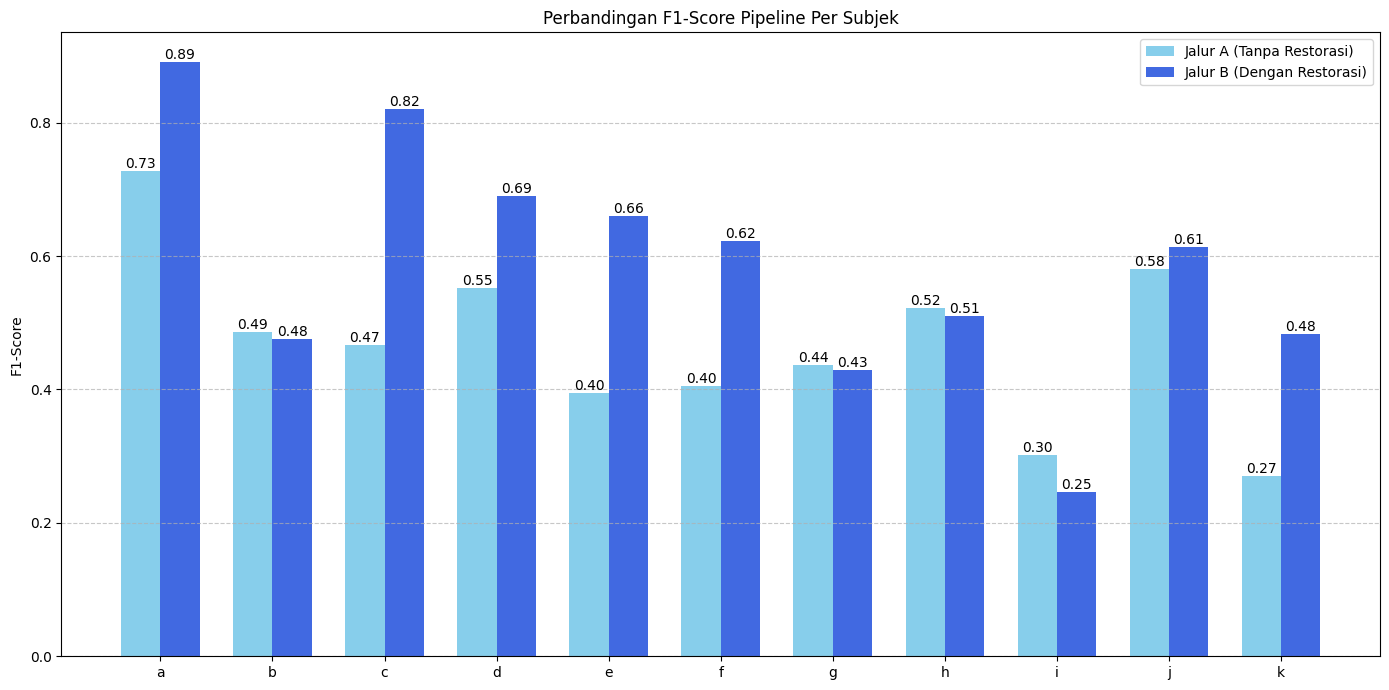


--- Visualisasi Tabel: Detail Metrik Per Subjek ---
Tabel metrik disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\metrics_table.png


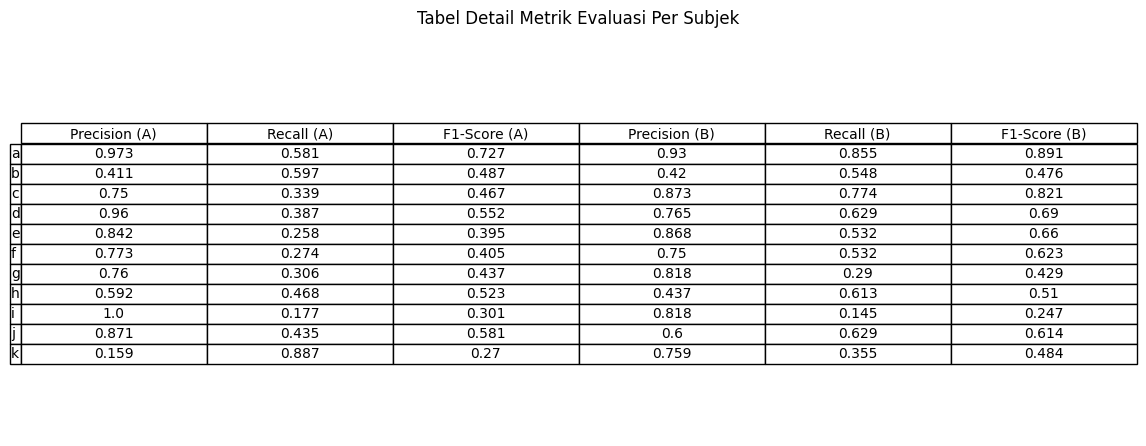

In [53]:
# Panggil fungsi evaluasi dengan variabel 'results' yang sudah ada
if 'results' in locals() and len(results) > 0:
    evaluate_and_print_per_subject(results)
else:
    print("Variabel 'results' belum ada. Pastikan Anda sudah menjalankan sel 'Langkah 5' terlebih dahulu.")

### Langkah 7.1: Matrik Kebingungan - Confusion Matrix


In [ ]:
try:
  import sklearn
except ImportError:
  print("Menginstal scikit-learn...")
  %pip install scikit-learn
try:
  import seaborn
except ImportError:
  print("Menginstal seaborn...")
  %pip install seaborn

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(results, pipeline_type, labels):
    """
    Membuat dan menampilkan confusion matrix untuk pipeline yang dipilih.
    """
    if pipeline_type == 'A':
        title = 'Confusion Matrix - Jalur A (Tanpa Restorasi)'
        pred_key = 'prediction_A'
    else:
        title = 'Confusion Matrix - Jalur B (Dengan Restorasi)'
        pred_key = 'prediction_B'
    # --- Persiapan Data ---
    # 1. Filter hasil: hanya gunakan gambar dengan 1 subjek ground truth agar matriksnya jelas(11x11)
    # 2. Filter hasil: hanya gunakan prediksi yang tidak None
    filtered_results = [r for r in results if len(r['ground_truth']) == 1 and r[pred_key] is not None]
    if not filtered_results:
        print(f"Tidak ada data valid untuk membuat confusion matrix {pipeline_type}.")
        return
    y_true = [r['ground_truth'] for r in filtered_results]
    y_pred = [r[pred_key] for r in filtered_results]
    # --- Membuat Matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # --- Membuat Visualisasi Heatmap ---
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                linewidths=.5)
    plt.title(title, fontsize=15)
    plt.ylabel('Label Sebenarnya (True Label)')
    plt.xlabel('Label Prediksi (Predicted Label)')
    # Simpan gambar
    file_path = os.path.join(RESULTS_PATH, f'confusion_matrix_{pipeline_type}.png')
    plt.savefig(file_path, bbox_inches='tight')
    print(f"Confusion Matrix untuk Jalur {pipeline_type} disimpan di: {file_path}")
    plt.show()

Confusion Matrix untuk Jalur A disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\confusion_matrix_A.png


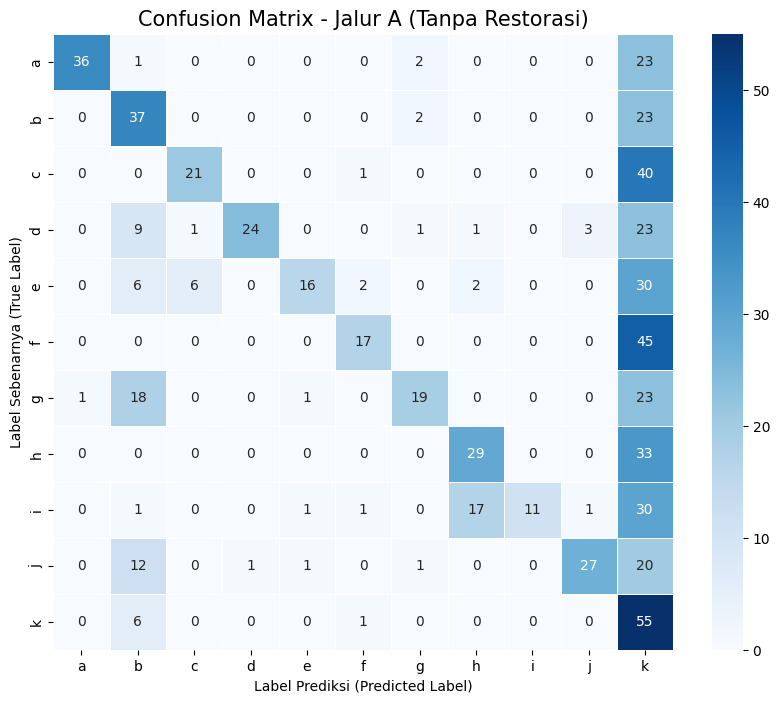

Confusion Matrix untuk Jalur B disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results\confusion_matrix_B.png


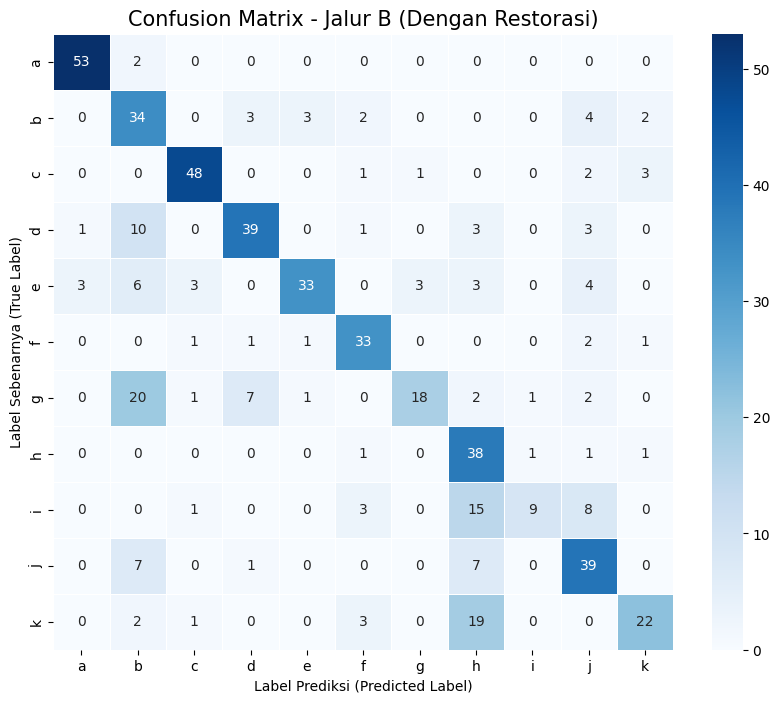

In [61]:
if 'results' in locals() and len(results) > 0:
    unique_labels = sorted(list(set(r['ground_truth'] for r in results if len(r['ground_truth'])== 1)))
    plot_confusion_matrix(results, 'A', unique_labels)
    plot_confusion_matrix(results, 'B', unique_labels)
else:
    print("Variabel 'results' belum ada. Pastikan Anda sudah menjalankan sel 'Langkah 5'terlebih dahulu.")

### Langkah 8: Kesimpulan (Template)

_(Bagian ini adalah template untuk Anda isi sebagai bagian dari analisis skripsi Anda)_

**Analisis Hasil Jarak:**
Berdasarkan tabel 'Analisis Berdasarkan Jarak', terlihat bahwa performa F1-Score untuk Jalur A (tanpa restorasi) menurun secara signifikan seiring dengan bertambahnya jarak. Pada kategori 'jauh', akurasinya adalah [...], sedangkan pada kategori 'dekat' adalah [...]. Di sisi lain, Jalur B (dengan restorasi GFPGAN) menunjukkan penurunan yang lebih landai. Peningkatan F1-Score terbesar terlihat pada kategori 'jauh', yaitu sebesar [...], yang menunjukkan bahwa restorasi citra sangat efektif dalam mengembalikan informasi wajah yang hilang akibat jarak.

**Analisis Hasil Ketinggian:**
Dari tabel 'Analisis Berdasarkan Ketinggian', kita dapat mengamati [...]. Perbedaan performa antara ketinggian 'rendah' dan 'tinggi' untuk Jalur A adalah [...]. Jalur B berhasil meningkatkan F1-Score pada kedua skenario, dengan peningkatan yang lebih terasa pada ketinggian [...]. Hal ini mengindikasikan bahwa [...].

**Kesimpulan Umum:**
Secara keseluruhan, hasil eksperimen ini secara kuantitatif membuktikan bahwa integrasi GFPGAN ke dalam pipeline rekognisi wajah (Jalur B) secara konsisten memberikan performa yang lebih unggul dibandingkan dengan rekognisi langsung pada citra resolusi rendah (Jalur A). Manfaat terbesar dari restorasi terasa pada kondisi pencitraan yang paling menantang, seperti jarak jauh dan sudut pengambilan gambar yang tinggi.
